In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 데이터 불러오기
customer_data = pd.read_csv('20260116_142718_customer_data_balanced.csv')

In [3]:
y = customer_data['IsChurn']
X = customer_data.drop(columns=['IsChurn'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# 전처리
# IsChurn -> OneHotEncoding / 나머지 -> StandardScaler

cat_cols = cat_cols = ["ContractType"]
num_cols = [c for c in customer_data.columns if c not in cat_cols + ["IsChurn"]]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

X_train_p = preprocess.fit_transform(X_train)
X_test_p = preprocess.transform(X_test)


In [ ]:
# 클래스 불균형 처리: class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("[class_weight]", class_weight)

[class_weight] {0: 0.8048289738430584, 1: 1.3201320132013201}


In [10]:
# 모델 구성
model = Sequential([
    Input(shape=(X_train_p.shape[1],)), # 입력층
    Dense(64, activation='relu'), # 은닉층1
    Dropout(0.3), # 과적합 방지
    Dense(32, activation='relu'), # 은닉층2
    Dropout(0.2), # 과적합 방지
    Dense(1, activation='sigmoid') # 출력층
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 과적합 방지
early_stopping = EarlyStopping(
    monitor='val_loss', # 검증 손실을 모니터링
    patience=5, # 몇 epoch 동안 개선이 없으면 중단
    restore_best_weights=True # 최적의 가중치 복원
)

history = model.fit(
    X_train_p, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4492 - loss: 0.6829 - val_accuracy: 0.6000 - val_loss: 0.6678
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5813 - loss: 0.6565 - val_accuracy: 0.6187 - val_loss: 0.6483
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6297 - loss: 0.6409 - val_accuracy: 0.6313 - val_loss: 0.6359
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 0.6249 - val_accuracy: 0.6344 - val_loss: 0.6299
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 0.6231 - val_accuracy: 0.6281 - val_loss: 0.6275
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6547 - loss: 0.6205 - val_accuracy: 0.6344 - val_loss: 0.6255
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6555 - loss: 0.6190 - val_accuracy: 0.6531 - val_loss: 0.6194
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6711 - loss: 0.6128 - val_accuracy: 0.6469 - val_loss:

In [11]:
# 모델 평가
y_pred_prob = model.predict(X_test_p)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.6725
F1 Score: 0.45643153526970953
Confusion Matrix:
 [[214  34]
 [ 97  55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.86      0.77       248
           1       0.62      0.36      0.46       152

    accuracy                           0.67       400
   macro avg       0.65      0.61      0.61       400
weighted avg       0.66      0.67      0.65       400



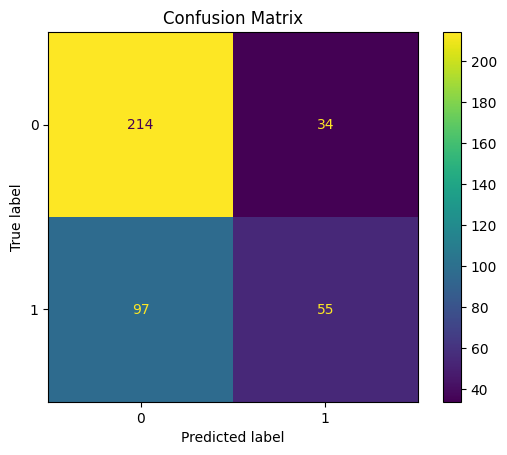

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()